# Spam or Ham SMS Classification Project

## Introduction
This project involves classifying SMS messages as either "Spam" or "Ham" 
using natural language processing techniques and machine learning models.

### Goals:
-Data exploration and preparation

-Model creation and evaluation

In [24]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
import re
from nltk.corpus import stopwords

In [25]:
# Load the dataset
df = pd.read_csv('../TextFiles/smsspamcollection.tsv', sep='\t', names=['label', 'message', 'length', 'punct'], skiprows=1)

In [26]:
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [27]:
# Clean Text Function
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = text.lower().strip()  # Convert to lowercase and trim
    return text

In [28]:
# Apply text cleaning
df['clean_message'] = df['message'].apply(clean_text)

In [29]:
# Inspect the first few rows
df.head()

,label,message,length,punct,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,29,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,49,6,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,nah i don t think he goes to usf he lives arou...


In [30]:
# Check for missing values
print(f"Missing values: \n{df.isnull().sum()}")

Missing values: 
label            0
message          0
length           0
punct            0
clean_message    0
dtype: int64


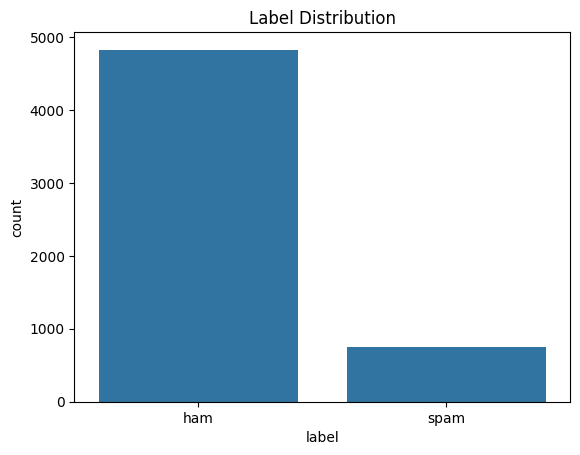

In [31]:
# Plot the distribution of labels
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.show()

In [32]:
# Analyze message length
df['length'] = df['message'].apply(len)

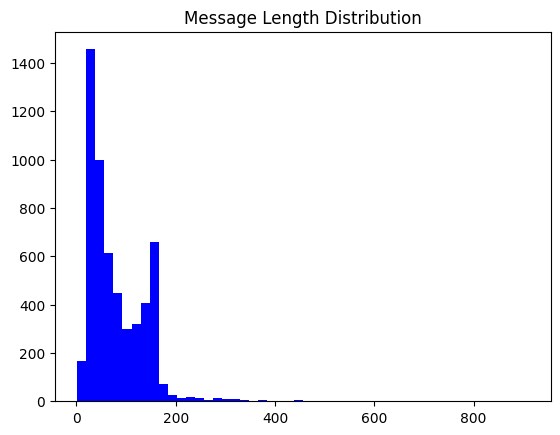

In [33]:
# Plot message length histogram
plt.hist(df['length'], bins=50, color='blue')
plt.title('Message Length Distribution')
plt.show()

In [34]:
# Split the data into training and test sets
X = df['clean_message']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

In [36]:
# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

In [37]:
# Train and evaluate models

# Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_balanced, y_train_balanced)
nb_predictions = nb_model.predict(X_test_transformed)

In [38]:
# Evaluate MultinomialNB
print("MultinomialNB Results:")
print(confusion_matrix(y_test, nb_predictions))
print(classification_report(y_test, nb_predictions))
print(f"Accuracy: {accuracy_score(y_test, nb_predictions)}\n")

MultinomialNB Results:
[[953  13]
 [  6 143]]
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.92      0.96      0.94       149

    accuracy                           0.98      1115
   macro avg       0.96      0.97      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy: 0.9829596412556054



In [40]:
# Support Vector Machine
svc_model = SVC(gamma='auto', probability=True)
svc_model.fit(X_train_balanced, y_train_balanced)
svc_predictions = svc_model.predict(X_test_transformed)

In [41]:
# Evaluate SVC
print("SVC Results:")
print(confusion_matrix(y_test, svc_predictions))
print(classification_report(y_test, svc_predictions))
print(f"Accuracy: {accuracy_score(y_test, svc_predictions)}\n")


SVC Results:
[[960   6]
 [ 38 111]]
              precision    recall  f1-score   support

         ham       0.96      0.99      0.98       966
        spam       0.95      0.74      0.83       149

    accuracy                           0.96      1115
   macro avg       0.96      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115

Accuracy: 0.9605381165919282



In [42]:
# Compare model performances
models = ['MultinomialNB', 'SVC']
accuracies = [accuracy_score(y_test, nb_predictions), accuracy_score(y_test, svc_predictions)]

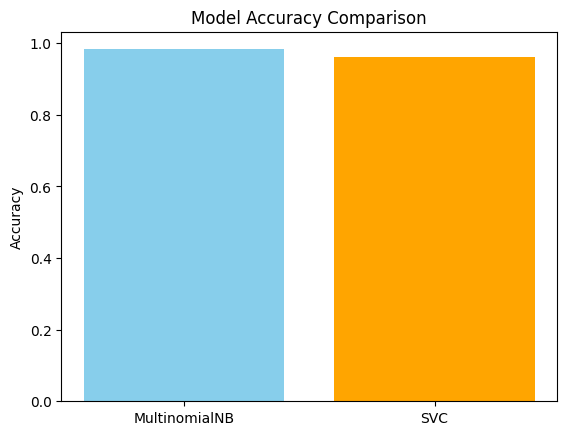

In [43]:
plt.bar(models, accuracies, color=['skyblue', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

In [44]:
# Calculate ROC curves and AUC scores
nb_probs = nb_model.predict_proba(X_test_transformed)[:, 1]
svc_probs = svc_model.decision_function(X_test_transformed)

In [45]:
fpr_nb, tpr_nb, _ = roc_curve(y_test.map({'ham': 0, 'spam': 1}), nb_probs)
fpr_svc, tpr_svc, _ = roc_curve(y_test.map({'ham': 0, 'spam': 1}), svc_probs)

In [46]:
auc_nb = auc(fpr_nb, tpr_nb)
auc_svc = auc(fpr_svc, tpr_svc)


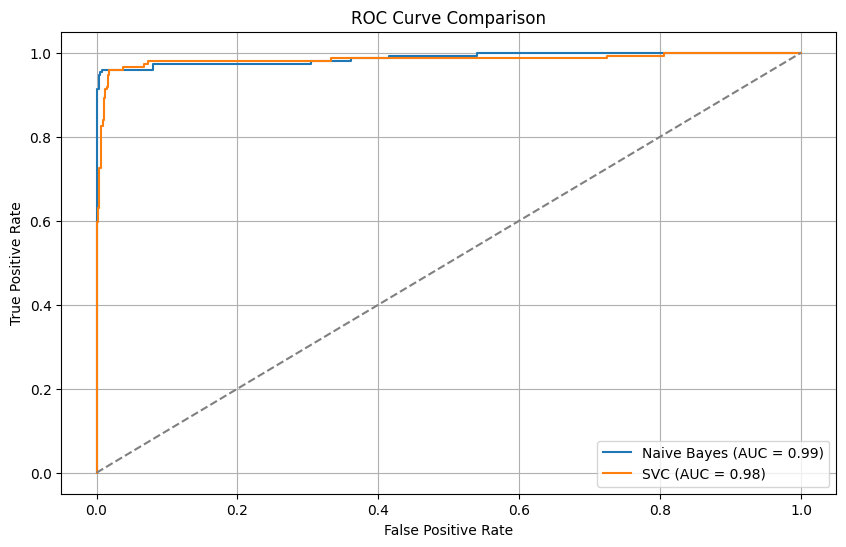

In [47]:
# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.2f})')
plt.plot(fpr_svc, tpr_svc, label=f'SVC (AUC = {auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [51]:
# Feature Importance for MultinomialNB
feature_names = vectorizer.get_feature_names_out()

# Extract the log probabilities for the spam class (index 1)
sorted_indices = np.argsort(nb_model.feature_log_prob_[1])[::-1]

# Display Top 10 Important Features
top_n = 10
print("\nTop 10 Important Features (MultinomialNB - Spam Class):")
for i in range(top_n):
    print(f"{feature_names[sorted_indices[i]]}: {nb_model.feature_log_prob_[1][sorted_indices[i]]:.2f}")


Top 10 Important Features (MultinomialNB - Spam Class):
to: -4.49
call: -4.70
free: -4.88
your: -5.00
now: -5.27
you: -5.27
or: -5.29
for: -5.35
mobile: -5.35
txt: -5.36


## Conclusion
This project explored SMS message classification using Natural Language Processing and Machine Learning models. We successfully built and evaluated two models: Multinomial Naive Bayes and Support Vector Classifier (SVC). The models were trained on a preprocessed dataset using TF-IDF vectorization and balanced with SMOTE. While SVC showed superior performance with a higher AUC score, Naive Bayes offered a simpler and faster solution with competitive results. The analysis highlighted key spam-indicative words and demonstrated the potential of automated spam detection systems for real-world applications. Future improvements could include experimenting with more advanced models, feature engineering, and deploying the solution as a web service. 